In [ ]:


from matplotlib import pyplot as plt
from conversion import gps_to_local, polar_to_cartesian, lidar_to_map
from occupancy_grid import map_to_grid,create_occupancy_grid,update_grid_from_scan,inflate_obstacles

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
import redis
import json

In [3]:
grid=create_occupancy_grid()

In [4]:
def plot_points(points):
    xs=[]
    ys=[]
    for point in points:

        x,y=point
        xs.append(x)
        ys.append(y)
    
    plt.figure(figsize=(6,6))
    plt.scatter(xs, ys, s=5)
    plt.scatter(0, 0, c='red', label="LiDAR")  # LiDAR
    plt.axis("equal")
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()

Listening for LiDAR data...


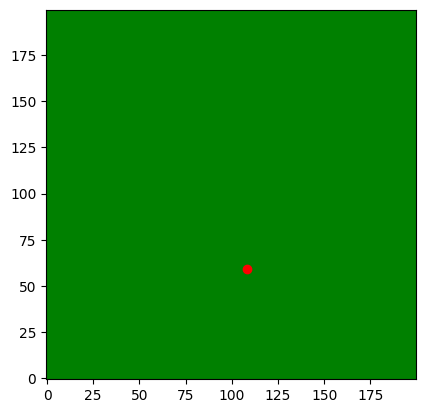

KeyboardInterrupt: 

In [5]:
r =redis.Redis(host='localhost',port=6379,decode_responses=True)
pubsub=r.pubsub()
pubsub.subscribe("lidar:scan")
print("Listening for LiDAR data...")
scan_points=[]
scan_count=0


plt.ion()
fig, ax = plt.subplots()
cmap = ListedColormap(["green", "red", "white"])
img = ax.imshow(grid.T, cmap=cmap, origin='lower',interpolation='nearest')
for message in pubsub.listen():
    # print(message)
    if message['type']=='message':
        data=json.loads(message['data'])
        points=data['points']  
        drone_pos=data['drone_pose']
        timestamp=data['timestamp']
        # print(f"Received LiDAR scan with {len(points)} points at timestamp {timestamp}")
        # plot_points(points)
        distance_m= [np.sqrt(p[0]**2 + p[1]**2) for p in points]
        x_d, y_d, yaw= drone_pos
        update_grid_from_scan(points,distance_m, grid, (x_d, y_d, yaw))
        INFLATION_RADIUS_CELLS = 5
        inflated_grid = inflate_obstacles(grid, INFLATION_RADIUS_CELLS)
        
        gx,gy=map_to_grid(x_d,y_d)
        ax.plot(gx, gy, 'ro')

        img.set_data(inflated_grid)
        plt.pause(0.01)

In [ ]:
# Drone pose (simulated)
x_d, y_d = 0.0, 0.0  # coordinates of the drone in the map  frame ( will get from the gps and imu  )
yaw = 0.0  # degrees

In [ ]:
from occupancy_grid import create_occupancy_grid, inflate_obstacles,update_grid_from_scan

In [ ]:

# Create grid
grid = create_occupancy_grid()

# Run multiple scans
for _ in range(1):
    scan = simulate_lidar_scan()
    points_map = []
    distance_m = []

    for p in scan:
        d_m = p["distance_mm"]
        x_l, y_l = polar_to_cartesian(p["angle_deg"], p["distance_mm"])
        x_m, y_m = lidar_to_map(x_l, y_l, x_d, y_d, yaw)
        points_map.append((x_m, y_m))
        distance_m.append(d_m)
    update_grid_from_scan(points_map,distance_m, grid, (x_d, y_d, yaw))
        
   


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [ ]:


cmap = ListedColormap(["green", "red", "white"])
# green = unknown, red = obstacle, white = free

plt.figure(figsize=(6,6))
plt.imshow(grid.T, origin="lower", cmap=cmap)
plt.title("Occupancy Grid with Free Space")
plt.xlabel("X cells")
plt.ylabel("Y cells")
plt.show()


In [ ]:


cmap = ListedColormap(["green", "red", "white"])
# black = unknown, white = obstacle (inflated), white = free

plt.figure(figsize=(6,6))
plt.imshow(inflated_grid.T, origin="lower", cmap=cmap)
plt.title("Occupancy Grid after Obstacle Inflation")
plt.xlabel("X cells")
plt.ylabel("Y cells")
plt.show()

In [ ]:
# Example start & goal (map coordinates)
x_start, y_start = 0.0, 0.0          # sprayer drone
x_goal, y_goal = 8.0, 8.0
        # crop location

start_cell = map_to_grid(x_start, y_start)
goal_cell  = map_to_grid(x_goal, y_goal)

# if inflated_grid[start_cell]!=2:
#         print(inflated_grid[start_cell])
#         print(f"Start cell {start_cell} is not free!")
#         start_cell =nearest_free_cell(inflated_grid, start_cell)
#         print(f"New start cell: {start_cell}")
# if inflated_grid[goal_cell]!=2:
#         print(inflated_grid[goal_cell])
#         print(f"Goal cell {goal_cell} is not free!")
#         goal_cell =nearest_free_cell(inflated_grid, goal_cell)
#         print(f"New goal cell: {goal_cell}")

path = astar(inflated_grid, start_cell, goal_cell)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.imshow(inflated_grid.T, origin="lower", cmap="gray")

if path:
    px = [p[0] for p in path]
    py = [p[1] for p in path]
    plt.plot(px, py, 'r')

plt.scatter(start_cell[0], start_cell[1], c='green', label="Start")
plt.scatter(goal_cell[0], goal_cell[1], c='blue', label="Goal")
plt.legend()
plt.title("A* Path Planning")
plt.show()


In [ ]:
# Map parameters
MAP_SIZE = 40.0        # meters (40 x 40)
RESOLUTION = 0.2       # meters per cell
GRID_SIZE = int(MAP_SIZE / RESOLUTION)

In [ ]:
from grid_to_map import grid_to_map

map_path = []

for gx, gy in path:
    x, y = grid_to_map(gx, gy, MAP_SIZE, RESOLUTION)
    map_path.append((x, y))


In [ ]:
len(map_path)

# for point in map_path:
#     print(f"{point[0]:.2f}, {point[1]:.2f}")

In [ ]:
x_start, y_start = 0.0, 0.0          # sprayer drone
x_goal, y_goal = 8.0, 6.0
start_cell

xs, ys = zip(*map_path)

plt.figure(figsize=(5,5))
plt.plot(xs, ys, 'r', label="A* Path (Map frame)")
plt.scatter(x_start, y_start, c='green', label="Drone Start (0,0)")
plt.scatter(x_goal, y_goal, c='red', label="Drone Goal (8,6)")
plt.axis("equal")
plt.grid()
plt.legend()
plt.title("A* Path in Map Coordinates")
plt.show()


In [ ]:
from path_utils import simplify_path

simplified_path = simplify_path(map_path)


In [ ]:
len(simplified_path)


In [ ]:
xs_raw, ys_raw = zip(*map_path)
xs_s, ys_s = zip(*simplified_path)

plt.figure(figsize=(6,6))
plt.plot(xs_raw, ys_raw, 'r--', alpha=0.4, label="Original A* path")
# plt.plot(xs_s, ys_s, 'b-', linewidth=2, label="Simplified path")
plt.scatter(xs_raw, ys_raw, c='red', alpha=0.4)
plt.scatter(xs_s, ys_s, c='blue')
plt.axis("equal")
plt.grid()
plt.legend()
plt.title("Path Simplification")
plt.show()


In [ ]:
def has_line_of_sight(p1, p2, inflated_grid, map_size, resolution):
    """
    Checks if straight line between p1 and p2 is obstacle-free
    p1, p2: (x, y) in map coordinates
    """
    x1, y1 = p1
    x2, y2 = p2

    dist = ((x2 - x1)**2 + (y2 - y1)**2)**0.5
    steps = int(dist / resolution)

    for i in range(steps + 1):
        x = x1 + (x2 - x1) * i / steps
        y = y1 + (y2 - y1) * i / steps

        gx = int((x + map_size/2) / resolution)
        gy = int((y + map_size/2) / resolution)

        if inflated_grid[gx, gy] == 1:
            return False

    return True

In [ ]:
def smooth_path_los(path, inflated_grid, map_size, resolution):
    """
    Smooths path using line-of-sight pruning
    """
    if len(path) <= 2:
        return path

    smoothed = [path[0]]
    i = 0

    while i < len(path) - 1:
        j = len(path) - 1
        while j > i + 1:
            if has_line_of_sight(path[i], path[j],
                                 inflated_grid, map_size, resolution):
                break
            j -= 1
        smoothed.append(path[j])
        i = j

    return smoothed


In [ ]:
smoothed_path = smooth_path_los(
    simplified_path,
    inflated_grid,
    MAP_SIZE,
    RESOLUTION
)


In [ ]:
xs_s, ys_s = zip(*simplified_path)
xs_sm, ys_sm = zip(*smoothed_path)

plt.figure(figsize=(6,6))
plt.plot(xs_s, ys_s, 'b--', label="Simplified path")
plt.plot(xs_raw, ys_raw, 'r--', label="Raw path")
plt.plot(xs_sm, ys_sm, 'g-', linewidth=2, label="Smoothed path")
plt.scatter(xs_sm, ys_sm, c='green')
plt.scatter(xs_s, ys_s, c='blue')
plt.scatter(xs_raw, ys_raw, c='red', alpha=0.4)

plt.axis("equal")
plt.grid()
plt.legend()
plt.title("Path Smoothing (Line-of-Sight)")
plt.show()


In [ ]:

#this is the altitude and longitude of the origin point of the map ( take off location of the drone)
lat0 = 29.9450    # example latitude (degrees)
lon0 = 76.8173    # example longitude (degrees)


In [ ]:
from map_to_gps import map_to_gps

ALTITUDE = 10.0  # meters (fixed altitude)

gps_waypoints = []

for x, y in smoothed_path:
    lat, lon = map_to_gps(x, y, lat0, lon0)
    gps_waypoints.append((lat, lon, ALTITUDE))


In [ ]:
for point in gps_waypoints:
    print(f"Lat: {point[0]:.6f}, Lon: {point[1]:.6f}, Alt: {point[2]:.2f} m")

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.imshow(inflated_grid.T, origin="lower", cmap='gray')

if path:
    px = [p[0] for p in path]
    py = [p[1] for p in path]
    plt.plot(px, py, 'r')
if smoothed_path:
    sx = []
    sy = []
    for mx, my in smoothed_path:
        gx = int((mx + MAP_SIZE/2) / RESOLUTION)
        gy = int((my + MAP_SIZE/2) / RESOLUTION)
        sx.append(gx)
        sy.append(gy)
    plt.plot(sx, sy, 'g', linewidth=2)
if simplified_path:
    spx = []
    spy = []
    for mx, my in simplified_path:
        gx = int((mx + MAP_SIZE/2) / RESOLUTION)
        gy = int((my + MAP_SIZE/2) / RESOLUTION)
        spx.append(gx)
        spy.append(gy)
    plt.plot(spx, spy, 'b--', alpha=0.5)
    
plt.scatter(start_cell[0], start_cell[1], c='green', label="Start")
plt.scatter(goal_cell[0], goal_cell[1], c='blue', label="Goal")
plt.legend()
plt.title("A* Path Planning")
plt.show()
